In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,10)})

The CART (classification and regression tree) algorithm was cooked up by Leo Breiman, Jerome Friedman and Charles J. Stone in 1984.

### Algorithm

In [2]:
def compute_sum_split_variance(xs, y, v):
    '''xs - 1D array of scalars
        v - scalar to split on'''
    left = y[xs < v]
    right = y[xs > v]
    left_var = 0 if len(left) == 0 else ((left - left.mean()) ** 2).sum()
    right_var = 0 if len(right) == 0 else ((right - right.mean()) ** 2).sum()
    return  left_var + right_var

def node(i, s, p, c, l, r):
    return {'internal': i,
            'split': s,
            'p': p,
            'c':c,
            'l':l,
            'r':r}

def splitf(X, y, max_leaf_n):
    if X.shape[0] <= max_leaf_n:
        return node(False, None, None, y.mean(), None, None)
    lowest_var, best_p_idx, best_split = sys.float_info.max, None, None
    for p_idx in range(0, X.shape[1]):
        for n_idx in range(0, X.shape[0]):
            split = X[n_idx][p_idx]
            var = compute_sum_split_variance(X[:,p_idx], y, split)
            if var < lowest_var:
                lowest_var = var
                best_p_idx = p_idx
                best_split = split
    left_idxs = X[:, best_p_idx] < best_split
    right_idxs = X[:, best_p_idx] > best_split
    l = splitf(X[left_idxs], y[left_idxs], max_leaf_n)
    r = splitf(X[right_idxs], y[right_idxs], max_leaf_n)
    return node(True, best_split, best_p_idx, None, l, r) 

def predict(x, model):
    if not model['internal']:
        return model['c']
    if x[model['p']] <= model['split']:
        return predict(x, model['l'])
    else:
        return predict(x, model['r'])

### Visualisation

In [15]:
def fit_n_plot_contours(X, y, max_leaf_n):
    scatter_df = pd.concat([pd.DataFrame(X, columns=['x1', 'x2']), pd.Series(y, name='y')], axis=1)
    ax = sns.scatterplot(x='x1', y='x2', hue='y' ,data=scatter_df, palette='rocket')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx1 = np.linspace(xmin, xmax, 100)
    xx2 = np.linspace(ymin, ymax, 100)
    xx1, xx2 = np.meshgrid(xx1, xx2)
    grid_x = np.vstack([xx1.ravel(), xx2.ravel()]).T
    model = splitf(X, y, max_leaf_n)
    preds = np.array([predict(r, model) for r in grid_x])
    zz = preds.reshape(xx1.shape)
    plt.contourf(xx1,xx2,zz, alpha=0.4)
    plt.colorbar()

In [14]:
def plot_boundries(tree, xmin, xmax, ymin, ymax):
    if not tree['internal']:
        x = xmin + (0.5 * (xmax - xmin))
        y = ymin + (0.5 * (ymax - ymin))
        plt.text(x, y, round(tree['c'], 3))
        return
    s = tree['split']
    if tree['p'] == 0:
        plt.plot([s, s], [ymin, ymax], c='black')
        plot_boundries(tree['l'], xmin, s, ymin, ymax)
        plot_boundries(tree['r'], s, xmax, ymin, ymax)
    else:
        plt.plot([xmin, xmax],[s, s], c='black')
        plot_boundries(tree['l'], xmin, xmax, ymin, s)
        plot_boundries(tree['r'], xmin, xmax, s, ymax)
        
def fit_n_plot_boundries(X, y):
    scatter_df = pd.concat([pd.DataFrame(X, columns=['x1', 'x2']), pd.Series(y, name='y')], axis=1)
    ax = sns.scatterplot(x='x1', y='x2', hue='y' ,data=scatter_df, palette='rocket')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    tree = splitf(X, y, max_leaf_n)
    plot_boundries(tree, xmin, xmax, ymin, ymax)

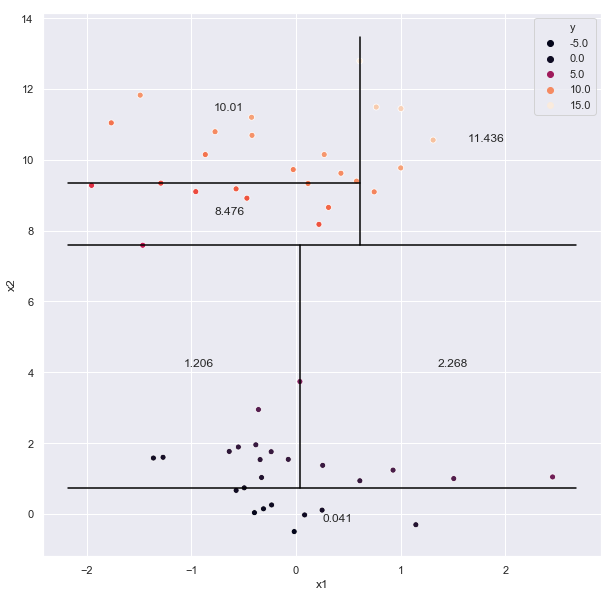

In [18]:
n = 100
k = 4
class_1 = np.random.normal([0, 1], 1, (n//k, 2))
class_2 = np.random.normal([0, 10], 1,(n//k, 2))
df = pd.concat([pd.DataFrame(class_1),
                pd.DataFrame(class_2)], axis=0, ignore_index=True)
X = df.values
y = X.sum(axis=1)
max_leaf_n = 10

fit_n_plot_boundries(X,y)

In [20]:
fit_n_plot_contours(X,y)

TypeError: fit_n_plot_contours() missing 1 required positional argument: 'max_leaf_n'